In [ ]:
bike sharing 미니프로젝트

#1.데이터 불러오기
#2.중복확인
#3.datetime 에서 년/월/일/시 에 따른 "평균"대여량 구하기. => 분석결과 도출
#4.근무일 유무/요일/시즌/날씨에 따른 "시간대별" 자전거 대여량
#5."연도별" "월별" 자전거 대여량 구하기.
#6. 이상치 제거 : 정상범위 데이터(count열값-count열값평균 < 3*count열값 표준편차)

#7. 시즌 필드 원핫인코딩
#8.풍속등 각 필드에 들어가있는 0값 => 보간(근사값으로 보정) 
#9. 조건문으로 대여수 예측 (if문)

----------------------------------------------------------------------------------------------------
#. windspeed (knn : 각 영향을 미치는 feature (weather, temp, humidity)를 표준화후 )

In [221]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")

from datetime import datetime

In [222]:
train=pd.read_csv("train.csv", parse_dates=["datetime"]) #csv파일 불러올때 parse_dates로 읽어오면 자동으로 
                                                              #object이 아닌 datetime으로 불러옴
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [223]:
#중복확인
train.duplicated().sum()

0

In [224]:
train.info()
train.isnull().sum() #Na값은 없으나 0값 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [225]:
#3.datetime 에서 년/월/일/시 에 따른 "평균"대여량 구하기. => 분석결과 도출 =>시각화

#mul_index=pd.MultiIndex.from_tuples([(train["datetime"].dt.year),(train["datetime"].dt.month)])
#mul_index

#train["datetime"].dt.year,train["datetime"].dt.month
#df_datemean=pd.DataFrame(train[["datetime","count"]],index=mul_index)
#df_datemean

In [226]:
date_y=train["datetime"].dt.year
date_m=train["datetime"].dt.month
date_d=train["datetime"].dt.date

In [253]:
year_y=train.groupby(date_y)["count"].transform(func="mean")#2011년 count 평균 144.223349, 2012년 count 평균 238.560944 
year_m=train.groupby(date_m)["count"].transform(func="mean") # 월별로 count평균
year_d=train.groupby(date_d)["count"].transform(func="mean") # 일별로 count평균
year_d.max()

345.5833333333333

In [228]:
#4.근무일 유무/요일/시즌/날씨에 따른 "시간대별" 자전거 대여량


In [233]:
#5."연도별" "월별" 자전거 대여량 구하기.
#train.groupby(date_y)["count"].value_counts()



datetime  count
2011      3        95
          5        91
          4        89
          2        80
          1        75
                   ..
2012      722       1
          725       1
          732       1
          733       1
          734       1
Name: count, Length: 1262, dtype: int64

(array([4284., 2337., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([-0.59504132, -0.19173554,  0.21157025,  0.61487603,  1.01818182,
         1.4214876 ,  1.82479339,  2.22809917,  2.63140496,  3.03471074,
         3.43801653]),
 <a list of 10 Patch objects>)

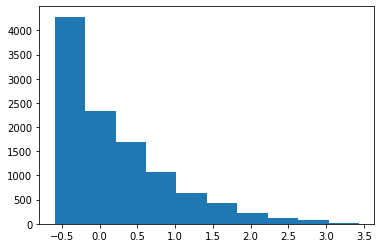

In [229]:
#6. 이상치 제거 : 정상범위 데이터(count열값-count열값평균 < 3*count열값 표준편차)
from sklearn.preprocessing import *
import matplotlib.pyplot as plt
#count열의 이상값 제거
np.median(train["count"]) #20.5
q1=np.percentile(train["count"],25) #1분위수 : 13.94
q3=np.percentile(train["count"],75) #3분위수 : 26.24
count=np.array(train["count"])

count_rs=RobustScaler().fit_transform(count.reshape(-1,1))  #이상값 분포 확인
plt.hist(count_rs)

In [230]:
train["count"].std()*3 
train=train[(train["count"]-train["count"].mean())<(train["count"].std()*3)]  #147개 이상값
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129


In [231]:
# day19 
#7. 시즌 필드 원핫인코딩
from sklearn.preprocessing import OneHotEncoder

season_ohe=pd.get_dummies(train["season"])
season_ohe.columns=["spring","summer","fall","winter"]

train=pd.concat([train, season_ohe],axis=1)
train

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,spring,summer,fall,winter
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3,13,16,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8,32,40,1,0,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5,27,32,1,0,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,10,13,1,0,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0,1,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10881,2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336,0,0,0,1
10882,2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241,0,0,0,1
10883,2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168,0,0,0,1
10884,2012-12-19 22:00:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129,0,0,0,1


In [ ]:
#8.풍속등 각 필드에 들어가있는 0값 => 보간(근사값으로 보정) 
train.set_index("datetime",inplace=True)
train

In [235]:
train.loc[train["windspeed"]==0,"windspeed"]=np.nan #windspeed의 0값을 모두 NaN으로 대체,후작업에서 NaN값을 보간해줄 예정이기 때문
train["windspeed"].isnull().sum()

1313

In [241]:
train["windspeed"].interpolate(method="time", limit_direction="backward", inplace=True) #datetime에 따른 windspeed NaN보간

## 추가내용 


In [ ]:
#wind_i=pd.Series(["windspeed"],index=datetime)
year=train["datetime"].dt.year
month=train["datetime"].dt.month
day=train["datetime"].dt.day
train["datetime"].dt.dayofweek #월0 #화1 #수2 #목3... # 주중/주말로 나누어서 자전거 대여수 예측가능
hour=train["datetime"].dt.hour
hour

import datetime
today="2020-01-17"
datetime.datetime.strptime(today, "%Y-%m-%d").date() 

datetime.datetime.today() #오늫 날짜 시간 정보 확인
datetime.datetime.today().strftime("%Y") #년도만 추출


In [ ]:
#test
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")

from datetime import datetime

In [250]:
test=pd.read_csv("test.csv", parse_dates=["datetime"]) #csv파일 불러올때 parse_dates로 읽어오면 자동으로 
                                                              #object이 아닌 datetime으로 불러옴
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014
...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981


In [251]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
datetime      6493 non-null datetime64[ns]
season        6493 non-null int64
holiday       6493 non-null int64
workingday    6493 non-null int64
weather       6493 non-null int64
temp          6493 non-null float64
atemp         6493 non-null float64
humidity      6493 non-null int64
windspeed     6493 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(5)
memory usage: 456.7 KB


In [259]:
# from sklearn.preprocessing import *
# import matplotlib.pyplot as plt
# #count열의 이상값 제거
# np.median(test["count"]) #20.5
# q1=np.percentile(test["count"],25) #1분위수 : 13.94
# q3=np.percentile(test["count"],75) #3분위수 : 26.24
# count=np.array(test["count"])

# count_rs=RobustScaler().fit_transform(count.reshape(-1,1))  #이상값 분포 확인
# plt.hist(count_rs)

In [255]:
from sklearn.preprocessing import OneHotEncoder

season_ohe=pd.get_dummies(test["season"])
season_ohe.columns=["spring","summer","fall","winter"]

test=pd.concat([test, season_ohe],axis=1)
test

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,spring,summer,fall,winter
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,1,0,0,0
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,1,0,0,0
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6488,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,1,0,0,0
6489,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,1,0,0,0
6490,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,1,0,0,0
6491,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,1,0,0,0


In [256]:
test.set_index("datetime",inplace=True)

In [257]:
test.loc[test["windspeed"]==0,"windspeed"]=np.nan #windspeed의 0값을 모두 NaN으로 대체,후작업에서 NaN값을 보간해줄 예정이기 때문
test["windspeed"].isnull().sum()

test["windspeed"].interpolate(method="time", limit_direction="backward", inplace=True) #datetime에 따른 windspeed NaN보간

In [258]:
test["count"]=

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,spring,summer,fall,winter
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.002700,1,0,0,0
2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,21.002267,1,0,0,0
2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,16.001833,1,0,0,0
2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.001400,1,0,0,0
2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.001400,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.001400,1,0,0,0
2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.001400,1,0,0,0
2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.001400,1,0,0,0
